<a href="https://colab.research.google.com/github/havaledar/S_Titanic_Kaggle_6100/blob/main/6100a2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

# Ethics


# Importing libraries and data

In [1]:
#from google.colab import drive #files
#uploaded = files.upload()
#drive.mount('/content/drive')

## Importing libraries

In [2]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

## Reading data

In [3]:
# read data
#train_data = pd.read_csv('drive/My Drive/6100/train.csv')
#test_data = pd.read_csv('drive/My Drive/6100/test.csv')
train_data = pd.read_csv('https://raw.githubusercontent.com/havaledar/S_Titanic_Kaggle_6100/main/train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/havaledar/S_Titanic_Kaggle_6100/main/test.csv')

train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Data Cleaning

What is done so far; let me know if you want to change anything/have any questions

*   Converted 'PassengerId' into TravelGroup (1/0)
*   Converted 'Name' into TravelWithFamily (1/0)
*   Separated 'Cabin' into 3 different variables (deck/num/side), Cabin_Num is converted into numbers while the other two are kept as categories
*   One-hot encode dummy variables (drop_first=True): Homeplanet, Cable_Deck, Cable_Side, Destination
*   Change to 1/0s: CryoSleep, VIP
*   NAs: Check code block that starts with 'deal with the rest of the NA values' to see what I did with each column
*   Used train_test_split to split the data to do cross-validation


TODO:
*   M: train both models
*   Meet at night tomorrow. Discuss what to write for the report later








In [4]:
#### Modify train and test data

# Transported is the value we want to predict
Transported = train_data['Transported']

# for data transformation

# Combine train and test
temp = [train_data, test_data]
# Remove Transported from train data to combine with test data
full_data = pd.concat(temp, keys=['train', 'test']).drop('Transported', axis=1)

#full_data.head()

In [5]:
### convert PassengerID into travel with group (1/0)

# get their groups
full_data['Group'] = full_data['PassengerId'].str.split('_').str[0]

# count if any other people belong in that group
full_data['GroupCount'] = full_data.groupby(['Group'])['PassengerId'].transform('count')

# create TravelGroup variable
full_data['TravelGroup'] = np.where(full_data['GroupCount'] > 1, 1, 0)

#full_data.head()

In [6]:
### convert Name into TravelWithFamily

# get their last names
full_data['LastName'] = full_data['Name'].str.split(' ').str[-1]

# create Group_LN variable (to check same group & same LN)
full_data['Group_LN'] = full_data['Group'] + full_data['LastName']

# create TravelWithFamily variable
full_data['FamilyCount'] = full_data.groupby(['Group_LN'])['PassengerId'].transform('count')
full_data['TravelWithFamily'] = np.where(full_data['FamilyCount'] > 1, 1, 0)

full_data[['Group_LN','TravelGroup','TravelWithFamily']][21:28]

Group_LN  TravelGroup  TravelWithFamily
train 21   0020Brantuarez            1                 1
      22   0020Brantuarez            1                 1
      23  0020Mcfaddennon            1                 1
      24  0020Jacostanley            1                 0
      25   0020Brantuarez            1                 1
      26  0020Mcfaddennon            1                 1
      27              NaN            0                 0

In [7]:
### convert Cabin into deck/num/side
Cabin = full_data['Cabin'].str.split('/')

full_data['Cabin_Deck'] = Cabin.str[0]

full_data['Cabin_Num'] = Cabin.str[1]
full_data['Cabin_Num'] = pd.to_numeric(full_data['Cabin_Num'], errors='coerce')

full_data['Cabin_Side'] = Cabin.str[2]

full_data[['Cabin_Deck','Cabin_Num','Cabin_Side']].head()

Cabin_Deck  Cabin_Num Cabin_Side
train 0          B        0.0          P
      1          F        0.0          S
      2          A        0.0          S
      3          A        0.0          S
      4          F        1.0          S

In [8]:
# convert T/F to 1/0 (fills na to False, which is 0)
tf_var = ['CryoSleep', 'VIP', 'TravelGroup', 'TravelWithFamily']
for var in tf_var:
  full_data[var] = np.where(full_data[var], 1, 0)

full_data[tf_var].head()

CryoSleep  VIP  TravelGroup  TravelWithFamily
train 0          0    0            0                 0
      1          0    0            0                 0
      2          0    1            1                 1
      3          0    0            1                 1
      4          0    0            0                 0

In [9]:
# deal with the rest of the NA values

# take means:
na_mean_var = ['Cabin_Num', 'Age']
for var in na_mean_var:
  full_data[var].fillna(full_data[var].mean(), inplace=True)
#full_data[na_mean_var].fillna(full_data[na_mean_var].mean(), inplace=True)

# take 0s:
na_zero_var = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for var in na_zero_var:
  full_data[var].fillna(0, inplace=True)
# full_data[na_zero_var].fillna(0, inplace=True)

# make NA a category
na_cate_var = ['HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Side']
for var in na_cate_var:
  full_data[var].fillna('NA', inplace=True)

In [10]:
# delete columns that are unneeded after the transformation
full_data.drop(columns=['Group', 'GroupCount', 'LastName', 
                        'Name', 'Group_LN', 'FamilyCount','Cabin'], inplace=True)

In [11]:
#one hot encode
categorical_var = ['HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Side']

full_data = pd.get_dummies(full_data, columns=categorical_var, drop_first=True)

full_data.head()

PassengerId  CryoSleep   Age  VIP  RoomService  FoodCourt  \
train 0     0001_01          0  39.0    0          0.0        0.0   
      1     0002_01          0  24.0    0        109.0        9.0   
      2     0003_01          0  58.0    1         43.0     3576.0   
      3     0003_02          0  33.0    0          0.0     1283.0   
      4     0004_01          0  16.0    0        303.0       70.0   

         ShoppingMall     Spa  VRDeck  TravelGroup  ...  Cabin_Deck_B  \
train 0           0.0     0.0     0.0            0  ...             1   
      1          25.0   549.0    44.0            0  ...             0   
      2           0.0  6715.0    49.0            1  ...             0   
      3         371.0  3329.0   193.0            1  ...             0   
      4         151.0   565.0     2.0            0  ...             0   

         Cabin_Deck_C  Cabin_Deck_D  Cabin_Deck_E  Cabin_Deck_F  Cabin_Deck_G  \
train 0             0             0             0             0             0   
      1             0             0             0             1             0   
      2             0             0             0             0             0   
      3             0             0             0             0             0   
      4             0             0             0             1             0   

         Cabin_Deck_NA  Cabin_Deck_T  Cabin_Side_P  Cabin_Side_S  
train 0              0             0             1             0  
      1              0             0             0             1  
      2              0             0             0             1  
      3              0             0             0             1  
      4              0             0             0             1  

[5 rows x 28 columns]

In [12]:
# split back to train and test
train_data = full_data.loc['train']
test_data = full_data.loc['test'] # this is our final test set for our results

# drop ids in training data as it's not needed
train_data = train_data.drop(columns=['PassengerId'])

# for training
x_train, x_test, y_train, y_test = train_test_split(train_data, Transported, test_size = 0.1, random_state = 20)



In [13]:
#testing
train_data['Cabin_Num']

0          0.0
1          0.0
2          0.0
3          0.0
4          1.0
         ...  
8688      98.0
8689    1499.0
8690    1500.0
8691     608.0
8692     608.0
Name: Cabin_Num, Length: 8693, dtype: float64

# Logisitic Regression



In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   int64  
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   int64  
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   TravelGroup                8693 non-null   int64  
 9   TravelWithFamily           8693 non-null   int64  
 10  Cabin_Num                  8693 non-null   float64
 11  HomePlanet_Europa          8693 non-null   uint8  
 12  HomePlanet_Mars            8693 non-null   uint8  
 13  HomePlanet_NA              8693 non-null   uint8

In [15]:
my_vars=train_data.columns

In [16]:
###
# Run logisitc regression
###

def LR_using_vars(my_var_list, X_train,Y_train,X_test,Y_test, Verbose=False): 
  #Do the logisitc regression using only the variables from my_var_list
  #Return the accuracy and CE_loss on the test set, as well as the entire model

  #Note: Set the "verbose" flag to true to print out lots of details
  if Verbose:
    print("-----------------------")
    print(f"Vars: {my_vars}")
    print("-----------------------")


  LR_model = LogisticRegression(fit_intercept=True, C=1e9) # Large C for no regularization
  LR_fit = LR_model.fit(X_train, Y_train)

  accuracy = LR_model.score(X_test,Y_test)
  preds = LR_model.predict_proba(X_test)[:,1]
  CE_loss = np.mean(-Y_test*np.log(preds) - (1-Y_test)*np.log(1-preds))
  if Verbose:
    print(f"  Test Accuracy:\n {accuracy:.3f}")
    print(f"  CE Loss:\n {CE_loss:.3f}")
    print("  Coeffs:")
    params_dict = dict(list(zip(my_var_list,list(LR_model.coef_[0]))))
    for item in params_dict.items():
        print(f'    {item[0]} : {item[1]:.3f}')

  return accuracy, CE_loss, LR_fit

In [18]:
print("Running Logistic Regression using all variables...")

accuracy,CE_loss,LR_model = LR_using_vars(my_vars, x_train,y_train,x_test,y_test,Verbose=True) 
#my_df['LR_prob'] = LR_model.predict_proba(train_data)[:,1]

Running Logistic Regression using all variables...
-----------------------
Vars: Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'TravelGroup', 'TravelWithFamily', 'Cabin_Num',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_NA',
       'Destination_NA', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Cabin_Deck_B', 'Cabin_Deck_C',
       'Cabin_Deck_D', 'Cabin_Deck_E', 'Cabin_Deck_F', 'Cabin_Deck_G',
       'Cabin_Deck_NA', 'Cabin_Deck_T', 'Cabin_Side_P', 'Cabin_Side_S'],
      dtype='object')
-----------------------
  Test Accuracy:
 0.784
  CE Loss:
 -0.996
  Coeffs:
    CryoSleep : 1.398
    Age : -0.007
    VIP : 0.032
    RoomService : -0.002
    FoodCourt : 0.001
    ShoppingMall : 0.000
    Spa : -0.002
    VRDeck : -0.002
    TravelGroup : 0.191
    TravelWithFamily : 0.048
    Cabin_Num : 0.000
    HomePlanet_Europa : 1.130
    HomePlanet_Mars : 0.374
    HomePlanet_NA : 0.034
    Destination_NA 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [19]:
junk = test_data.drop(columns=['PassengerId'])
test_data['Transported'] = LR_model.predict(junk)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
answers = test_data[ ['PassengerId','Transported']  ]

answers.to_csv('answers.csv',index=False)

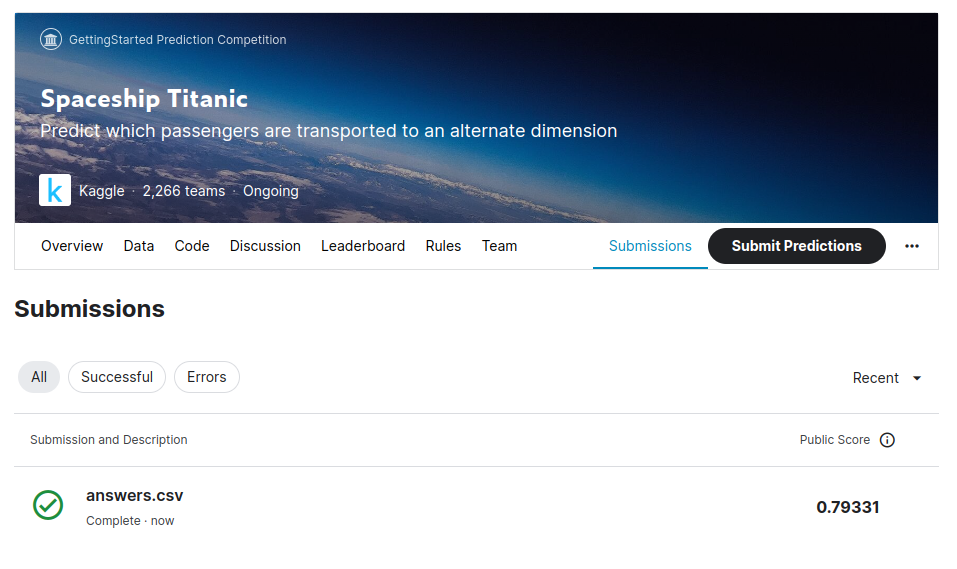

#Discriminant Analysis

#MH LDA test

In [ ]:
###
# Calculate mean and variance of all the 'Gaussian'-like variablels in my_gauss_vars
###

class_list = [0,1]

means = [dict.fromkeys(my_gauss_vars) for surviv_class in class_list]
stds = [dict.fromkeys(my_gauss_vars) for surviv_class in class_list]

for surviv_class in class_list:
  print(f"Survived = {surviv_class}")
  for feature in my_gauss_vars:
    v = np.array(df[ df['Survived'] == surviv_class ][feature])
    means[surviv_class][feature] = np.nanmean(v)
    stds[surviv_class][feature] = np.nanstd(v)
    #print(v)
    print(f'. {feature}: Mean: {np.nanmean(v):.3f}, STD: {np.nanstd(v):.3f}')

In [ ]:
# https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [32]:
y_train

8270     True
902     False
120     False
7187     True
3511     True
        ...  
5910     True
3915     True
7068    False
7391    False
4367    False
Name: Transported, Length: 7823, dtype: bool

In [31]:
x_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TravelGroup,TravelWithFamily,...,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_NA,Cabin_Deck_T,Cabin_Side_P,Cabin_Side_S
8270,1,21.0,0,0.0,0.0,0.0,0.0,0.0,1,1,...,0,0,0,0,1,0,0,0,0,1
902,0,21.0,0,0.0,314.0,323.0,1026.0,6.0,0,0,...,0,0,0,1,0,0,0,0,1,0
120,0,61.0,1,2353.0,334.0,9.0,316.0,2.0,1,1,...,0,0,1,0,0,0,0,0,0,1
7187,1,54.0,0,0.0,0.0,0.0,0.0,0.0,1,1,...,0,0,0,0,0,1,0,0,1,0
3511,0,20.0,0,0.0,0.0,422.0,0.0,0.0,1,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,1,33.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,1
3915,1,44.0,0,0.0,0.0,0.0,0.0,0.0,1,1,...,0,1,0,0,0,0,0,0,1,0
7068,0,41.0,0,0.0,0.0,0.0,0.0,908.0,0,0,...,0,0,0,0,0,1,0,0,1,0
7391,1,60.0,0,0.0,0.0,0.0,0.0,0.0,1,1,...,0,0,0,0,0,1,0,0,1,0


# Method 3

In [25]:
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis()


In [38]:
# make a prediction with a lda model on the dataset
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# define model
model = LinearDiscriminantAnalysis()
# fit model
model.fit(x_train, y_train)
# make a prediction
test_data['Transported_LDA'] = model.predict(junk)
# summarize prediction
test_data['Transported_LDA']

answers_LDA = test_data[ ['PassengerId','Transported_LDA']  ]
answers_LDA = answers_LDA.rename({'Transported_LDA': 'Transported'}, axis=1)
answers_LDA.to_csv('answers_LDA.csv',index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


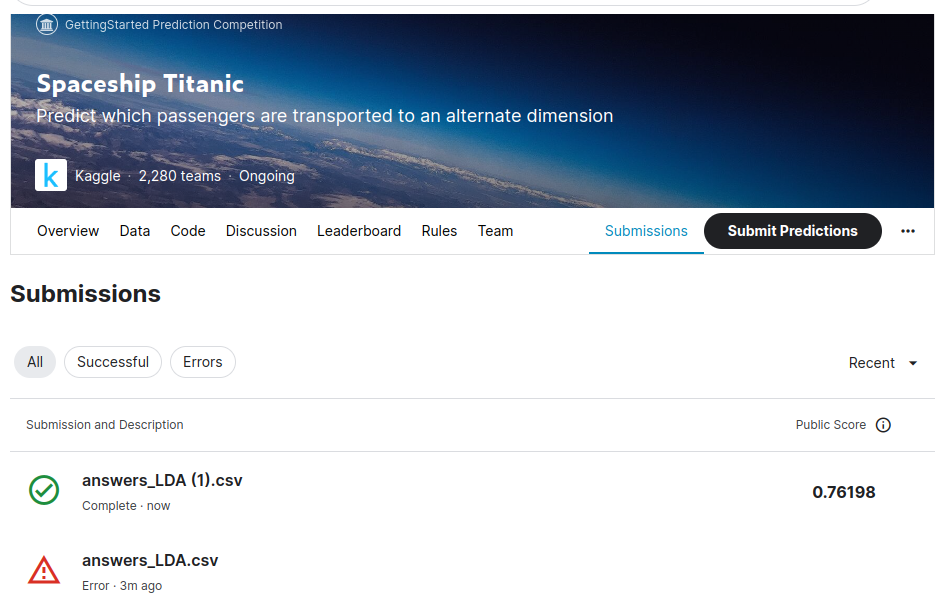